# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance 
from xgboost import plot_importance

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion, such as map days into numerical values. 

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [7]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

In [8]:
customer_booking = df

convert the categorical features to numerical.

In [9]:
for col in customer_booking.select_dtypes("object"):
    customer_booking[col],_ = customer_booking[col].factorize()

In [10]:
customer_booking.head(10)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,0,0,262,19,7,6,0,0,1,0,0,5.52,0
1,1,0,0,112,20,3,6,0,0,0,0,0,5.52,0
2,2,0,0,243,22,17,3,0,1,1,1,0,5.52,0
3,1,0,0,96,31,4,6,0,0,0,0,1,5.52,0
4,2,0,0,68,22,15,3,0,1,1,0,1,5.52,0
5,1,0,0,3,48,20,4,0,0,1,0,1,5.52,0
6,3,0,0,201,33,6,4,0,0,1,0,1,5.52,0
7,2,0,0,238,19,14,1,0,1,1,0,1,5.52,0
8,1,0,0,80,22,4,1,0,0,0,0,1,5.52,0
9,1,1,0,378,30,12,7,0,1,0,0,0,5.52,0


In [11]:
customer_booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  int64  
 2   trip_type              50000 non-null  int64  
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  int64  
 8   booking_origin         50000 non-null  int64  
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 5.3 MB


In [12]:
customer_booking['booking_complete'].value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

In [13]:
customer_booking['booking_complete'].value_counts(normalize=True)*100

0    85.044
1    14.956
Name: booking_complete, dtype: float64

## **Model Building**

In [14]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [15]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

**Normalized the dataset**

In [16]:
scaler = MinMaxScaler()
model = scaler.fit_transform(customer_booking)
scale_customer_booking = pd.DataFrame(model, columns = customer_booking.columns)
scale_customer_booking.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,0.125,0.0,0.0,0.302191,0.024422,0.304348,0.833333,0.0,0.000000,1.0,0.0,0.0,0.175983,0.0
1,0.000,0.0,0.0,0.129181,0.025707,0.130435,0.833333,0.0,0.000000,0.0,0.0,0.0,0.175983,0.0
2,0.125,0.0,0.0,0.280277,0.028278,0.739130,0.333333,0.0,0.009709,1.0,1.0,0.0,0.175983,0.0
3,0.000,0.0,0.0,0.110727,0.039846,0.173913,0.833333,0.0,0.000000,0.0,0.0,1.0,0.175983,0.0
4,0.125,0.0,0.0,0.078431,0.028278,0.652174,0.333333,0.0,0.009709,1.0,0.0,1.0,0.175983,0.0


In [17]:
scale_customer_booking.describe()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.073905,0.112360,0.00890,0.097971,0.029620,0.394189,0.469070,0.438934,0.194216,0.668780,0.296960,0.427140,0.539868,0.149560
std,0.127521,0.315812,0.09078,0.104327,0.043557,0.235333,0.332132,0.254174,0.162249,0.470657,0.456923,0.494668,0.309910,0.356643
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.024221,0.006427,0.217391,0.166667,0.230576,0.048544,0.000000,0.000000,0.000000,0.196687,0.000000
50%,0.000000,0.000000,0.00000,0.058824,0.021851,0.391304,0.500000,0.427318,0.097087,1.000000,0.000000,0.000000,0.600414,0.000000
75%,0.125000,0.000000,0.00000,0.132641,0.035990,0.565217,0.666667,0.677945,0.349515,1.000000,1.000000,1.000000,0.861284,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# Separate the dataset into labels (y) and features (X).

X = scale_customer_booking.drop(columns=['booking_complete'], axis=1)
y = scale_customer_booking['booking_complete']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify= y, random_state = 42)

**Random Forest Classifier**

In [20]:
rf = RandomForestClassifier(random_state=42)
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [300]
             }
scoring = {'accuracy', 'precision', 'recall', 'f1'}
rf_val = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')

In [21]:
%%time
rf_val.fit(X_train, y_train)

CPU times: user 3min 34s, sys: 1.78 s, total: 3min 36s
Wall time: 3min 48s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='f1', scoring={'f1', 'precision', 'accuracy', 'recall'})

In [22]:
# Examine best score
rf_val.best_score_

0.20678048801868015

In [23]:
rf_val.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [24]:
# Get scores on test data
rf_preds = rf_val.best_estimator_.predict(X_test)

In [25]:
# Call 'make_results()' on the GridSearch object
results = make_results('RF CV', rf_val, 'f1')
rf_test_scores = get_test_scores('RF test', rf_preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.495539,0.130683,0.20678,0.850053
0,RF test,0.504065,0.132691,0.21008,0.850800


**XGBoost Classifier**

In [26]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
# Note that this example only contains 1 value for each parameter for simplicity,
# but you should assign a dictionary with ranges of values
cv_params = {'learning_rate': [0.1],
             'max_depth': [8],
             'min_child_weight': [2],
             'n_estimators': [500]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

In [27]:
%%time
xgb1.fit(X_train, y_train)

CPU times: user 3min 54s, sys: 48 s, total: 4min 42s
Wall time: 1min 16s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

In [28]:
# Examine best score
xgb1.best_score_

0.23397431899493112

In [29]:
# Examine best parameters
xgb1.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 500}

In [30]:
# Get scores on test data
xgb_preds = xgb1.best_estimator_.predict(X_test)

In [31]:
# Call 'make_results()' on the GridSearch object
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis=0)
xgb_test_scores = get_test_scores('XGB test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.495539,0.130683,0.206780,0.850053
0,RF test,0.504065,0.132691,0.210080,0.850800
0,XGB CV,0.454575,0.157607,0.233974,0.845760
0,XGB test,0.462617,0.158909,0.236559,0.846640


The above results shows that XGBoost classifier perform compatively as the f1 score is 23.6% as compare to 21.0%.
Hence, overall the analysis required more data.

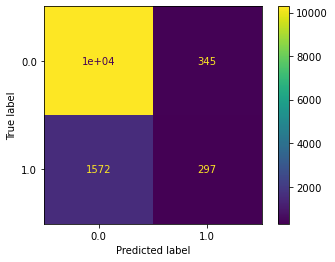

In [32]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_preds, labels=xgb1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb1.classes_)
disp.plot();

The confusion matrix shows that:-
- There are 1,572 labels which are predicted as label 0 although they are truely label as 1, hence, there are 1,572 label 1 predicted falsely.
- There are 345 labels which are predicted as label 1 although they are truely label as 0, hence, there are 345 label 0 predicted falsely.

- There are 1,000 labels which are predicted as label 0 and they are truely label as 1, hence, there are 1,000 label 0 predicted truely.
- There are 297 labels which are predicted as label 1 although they are truely label as 1, hence, there are 297 label 1 predicted truely.


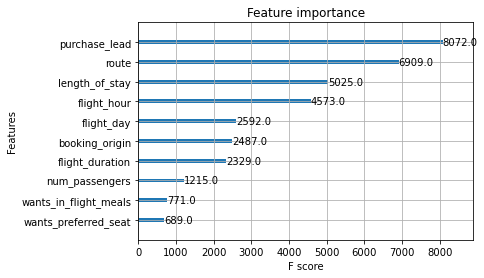

In [33]:
plot_importance(xgb1.best_estimator_, max_num_features=10);

- The most important variable in the model was purchase_lead, that is the time between purchase and departure.
- Information about the flight, e.g. flight route, time and duration was also significant.
- The accuracy of the model was approximately 0.85 (accuracy), 0.46(Precision), 0.16 (Recall) and 0.23(F1), showing that this model requires more improvement. Hence, more customer-centric features must be include into the model.